In [8]:
import gooseberry as gs
from dynamics import QQT
from tools import BlindColours, zero_balanced_weights

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

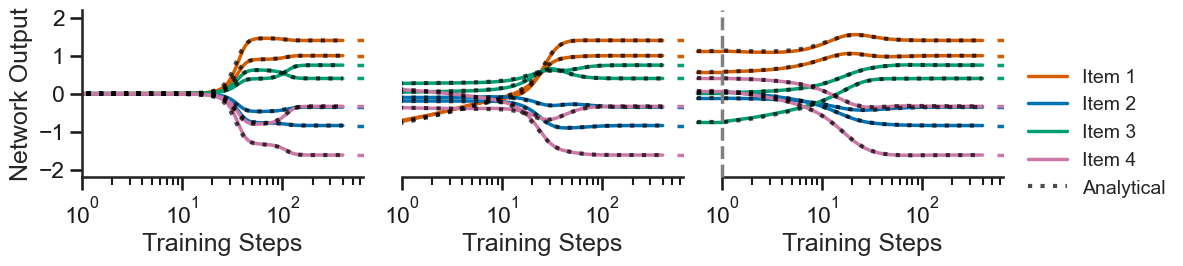

In [9]:
np.random.seed(1)

in_dim = 5
hidden_dim = 10
out_dim = 2

batch_size = 10
learning_rate = 0.1
training_steps = 400

plot_items_n = 4
blind_colours = BlindColours().get_colours()

init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, .35)
train, _, _ = gs.datasets.StudentTeacher(batch_size, [init_w1, init_w2], [gs.datasets.Whiten()])

fig, axs = plt.subplots(1, 3, figsize=(12, 3.))

for i, initial_scale in enumerate([0.01, .25, .25]):
    task = gs.tasks.FullBatchLearning(train)
    optimiser = gs.GradientDescent(learning_rate)
    loss = gs.MeanSquaredError()

    init_w1, init_w2 = zero_balanced_weights(in_dim, hidden_dim, out_dim, initial_scale)
    
    mlp = gs.Network([
        gs.Linear(hidden_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w1)),
        gs.Linear(out_dim, bias=False, weight_init=gs.init.FromFixedValue(init_w2))
    ])

    trainer = gs.Trainer(task, mlp, loss, optimiser)
    state, params = gs.assemble(1)

    losses = []
    ws = [params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"]]
    
    for training_step in range(training_steps):
        state, params, loss = trainer(state, params)
        losses.append(loss)
        ws.append(params["network"]["layer-1"]["w"] @ params["network"]["layer-0"]["w"])
    
    X, Y = train(None)
    analytical = QQT(init_w1, init_w2, X.T, Y.T, True)
    analytical = np.asarray([analytical.forward(learning_rate) for _ in range(training_steps)])
    

    outputs = (np.asarray(ws)[:, 0, :, :] @ X[:plot_items_n].T)
    for color, output in zip(blind_colours, outputs.T):
        for val in output:
            axs[i].plot(val, c=color, lw=2.5)
    axs[i].plot((analytical @ X[:plot_items_n].T).reshape(training_steps, -1), lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2))) # (0, (3, 4, 3, 1))
    
    for color, target in zip(blind_colours, Y[:plot_items_n]):
        for value in target:
            axs[i].scatter(training_steps * 1.6, value, marker="_", color=color, lw=2.5)
    
    axs[i].set_xlim(1, training_steps * 1.6)
    axs[i].set_ylim([-2.2, 2.2])
    
    axs[i].set_xscale("log")
    
    axs[i].set_xlabel("Training Steps")
    if i == 0:
        sns.despine(ax=axs[i])
        axs[i].set_ylabel("Network Output")
        axs[i].set_yticks([-2, -1., 0., 1., 2])
    else:
        sns.despine(ax=axs[i], left=True)
        axs[i].set_yticks([])

first_task = outputs[1]
rng = np.linspace(0.57, 1., 10)
for color, output in zip(blind_colours, first_task.T):
    for val in output:
        axs[2].plot(rng, [val]*10, c=color, lw=2.5, clip_on=False, zorder=1)
        axs[2].plot(rng, [val]*10, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), clip_on=False, zorder=2)
axs[2].axvline(1., linestyle="--", c="grey", lw=2.5, clip_on=False, zorder=3)

for n, (color) in enumerate(blind_colours[:plot_items_n]):
    axs[2].plot(-5, -5, c=color, lw=2.5, label=f"Item {n + 1}")
axs[2].plot(-5, -5, lw=3., c="k", alpha=0.7, linestyle=(0, (1, 2)), label="Analytical")

fig.legend(loc=7, fontsize=14, frameon=False)
fig.tight_layout()
fig.subplots_adjust(right=0.85)

fig.savefig("./figures/figure-1_b-c-d.svg")